Dominating set ≤ k: {1, 2}
Distance to nearest dominating node for each node:
  Node 1: 0.000
  Node 2: 0.000
  Node 3: 1.000
  Node 4: 1.000
  Node 5: 1.000


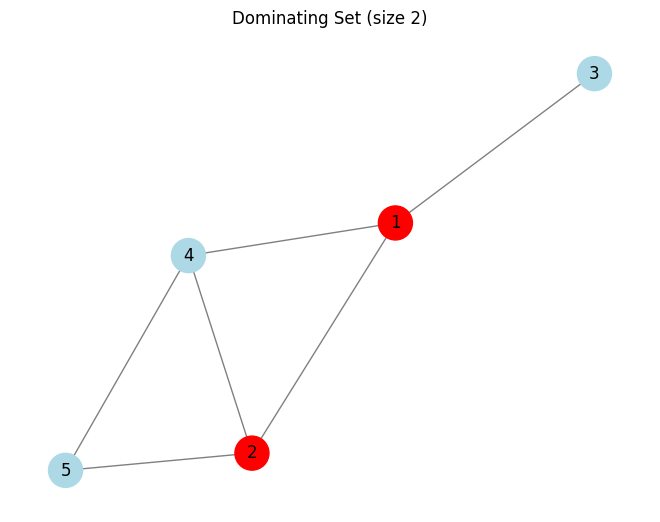


Min–Max multicenter (≤ k): (('node', 1), ('node', 2)) radius ≈ 1.0
Distance to nearest center for each node:
  Node 1: 0.000
  Node 2: 0.000
  Node 3: 1.000
  Node 4: 1.000
  Node 5: 1.000


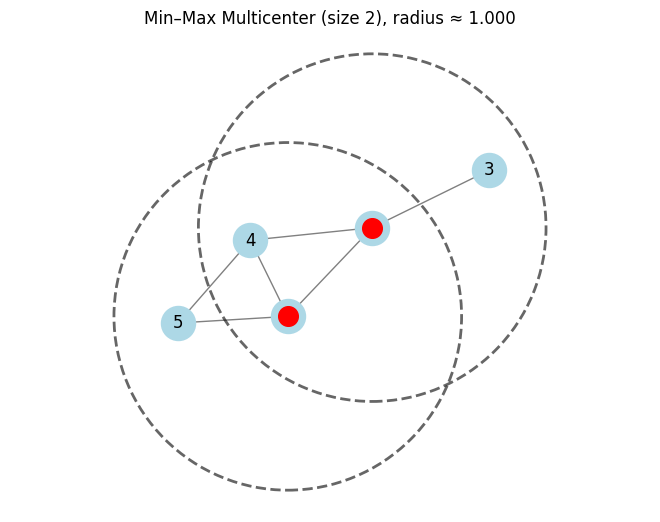


DS→Multicenter reduction feasible? True
Multicenter→DS reduction dominating set: {1, 2}


In [ ]:
import argparse
import os
import pandas as pd
import sys
import networkx as nx
import math
from itertools import combinations
import matplotlib.pyplot as plt

def find_dominating_set(G: nx.Graph, k: int):
    """
    Return a dominating set D of size ≤ k if one exists, else None.
    """
    nodes = list(G.nodes())
    n = len(nodes)
    for r in range(1, k+1):
        for subset in combinations(nodes, r):
            D = set(subset)
            dominated = set(D)
            for u in D:
                dominated.update(G.neighbors(u))
            if len(dominated) == n:
                return D
    return None

def plot_dominating_set(G: nx.Graph, D: set, pos=None):
    """
    Plot graph G highlighting dominating set D in red.
    """
    if pos is None:
        pos = nx.spring_layout(G)
    colors = ['red' if v in D else 'lightblue' for v in G.nodes()]
    nx.draw(G, pos, node_color=colors, edge_color='gray', with_labels=True, node_size=600)
    plt.title(f"Dominating Set (size {len(D)})")
    plt.axis('off')
    plt.show()

def all_candidate_positions(G: nx.Graph):
    """
    Continuous p-center candidates: all nodes + midpoints of every edge.
    """
    cands = [("node", v) for v in G.nodes()]
    for u, v, data in G.edges(data=True):
        cands.append(("edge", (u, v), 0.5))
    return cands

def dist_from_candidate_to_nodes(G: nx.Graph, candidate, sp_dist):
    """
    Given APSP distances sp_dist, return node->distance from candidate.
    """
    if candidate[0] == "node":
        _, v = candidate
        return sp_dist[v]
    _, (u, v), t = candidate
    w = G[u][v].get("weight", 1.0)
    du, dv = t*w, (1-t)*w
    d = {}
    for x in G.nodes():
        d[x] = min(sp_dist[u][x] + du, sp_dist[v][x] + dv)
    return d

def find_minmax_multicenter(G: nx.Graph, k: int):
    """
    Brute-force search for up to k continuous centers minimizing max distance.
    Returns (best_centers, best_radius).
    """
    sp_dist    = dict(nx.floyd_warshall(G, weight="weight"))
    candidates = all_candidate_positions(G)
    best, best_rad = None, math.inf

    for r in range(1, k+1):
        for combo in combinations(candidates, r):
            radius = 0.0
            for x in G.nodes():
                d_nearest = min(dist_from_candidate_to_nodes(G, c, sp_dist)[x] for c in combo)
                radius = max(radius, d_nearest)
                if radius >= best_rad:
                    break
            else:
                best_rad, best = radius, combo
    return best, best_rad

def plot_p_center(G: nx.Graph, centers, radius, pos=None):
    """
    Plot graph G, centers in red, with dashed coverage circles.
    """
    if pos is None:
        pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color="lightblue", edge_color="gray", with_labels=True, node_size=600)
    for c in centers:
        if c[0] == "node":
            _, v = c
            plt.scatter(*pos[v], c="red", s=200, zorder=3)
        else:
            _, (u, v), t = c
            x = pos[u][0]*(1-t) + pos[v][0]*t
            y = pos[u][1]*(1-t) + pos[v][1]*t
            plt.scatter(x, y, c="red", marker="X", s=200, zorder=3)
    ax = plt.gca()
    for c in centers:
        if c[0] == "node":
            _, v = c
            cx, cy = pos[v]
        else:
            _, (u, v), t = c
            cx = pos[u][0]*(1-t) + pos[v][0]*t
            cy = pos[u][1]*(1-t) + pos[v][1]*t
        circle = plt.Circle((cx, cy), radius, fill=False, linestyle="--", alpha=0.6, linewidth=2)
        ax.add_patch(circle)
    plt.title(f"Min–Max Multicenter (size {len(centers)}), radius ≈ {radius:.3f}")
    plt.axis('equal'); plt.axis('off')
    plt.show()


def pcenter_feasible(G: nx.Graph, p: int, R: float):
    """
    Decide whether ≤ p centres can cover every vertex within radius R.
    We discretise the continuous centres to:
        - every vertex  ('node', v)
        - every edge-midpoint  ('edge', (u,v), 0.5)

    Returns (True, witness_subset)  or  (False, None)
    where witness_subset is a tuple of candidate descriptors.
    """
    # --- 1.  all-pairs shortest-path distances
    sp = dict(nx.floyd_warshall(G, weight="weight"))

    # --- 2.  candidate list
    CAND = [("node", v) for v in G.nodes()]               # |V|
    CAND += [("edge", (u, v), 0.5) for u, v in G.edges()] # |E|

    # helper: distance from vertex x to a specific candidate c
    def d(x, c):
        if c[0] == "node":
            return sp[x][c[1]]
        (u, v), t = c[1], c[2]          # t = 0.5
        return min(sp[x][u] + t, sp[x][v] + (1 - t))

    # --- 3.  brute enumeration of all subsets of size ≤ p
    for r in range(1, p + 1):
        for subset in combinations(CAND, r):
            if all(min(d(x, c) for c in subset) <= R for x in G.nodes()):
                return True, subset      # ← YES with witness

    return False, None

def brute_find_dominating_set(G: nx.Graph, k: int):
    """
    Return a dominating set D (as a Python set) with |D| ≤ k
    if one exists, otherwise return None.

    Exponential in k – fine for toy graphs only.
    """
    for r in range(1, k + 1):
        for subset in combinations(G.nodes(), r):
            D = set(subset)
            dominated = set(D)
            for u in D:
                dominated.update(G.neighbors(u))
            if len(dominated) == G.number_of_nodes():
                return D          # ← witness
    return None


def reduce_ds_to_multicenter(G: nx.Graph, k: int, *, debug: bool = False):
    """
    Returns (G' , p=k , R=1) — *always* a 3-tuple.
    Internally does a brute-force search just to tell you (via print)
    whether the original DS instance was YES or NO.
    """
    witness = brute_find_dominating_set(G, k)
    if debug:
        if witness:
            print(f"[DS→p-center]  YES – dominating set: {witness}")
        else:
            print(f"[DS→p-center]  NO  – no dominating set of size ≤ {k}")

    # G' is simply an unweighted copy: every edge length = 1
    Gp = nx.Graph()
    Gp.add_nodes_from(G.nodes())
    Gp.add_edges_from((u, v, {"weight": 1.0}) for u, v in G.edges())

    return Gp, k, 1.0 


def reduce_multicenter_to_ds(G: nx.Graph, p: int, R: float,
                             *, debug: bool = False):
    """
    Returns (H , k=p).  Always a 2-tuple.
    Also prints a brute-force witness (or failure) if debug=True.
    """
    ok, witness = pcenter_feasible(G, p, R)
    if debug:
        if ok:
            print(f"[p-center→DS]  YES – covering set: {witness}")
        else:
            print(f"[p-center→DS]  NO  – cannot cover within R={R}")

    # Standard threshold graph H: edge (u,v) iff dist_G(u,v) ≤ R
    sp = dict(nx.floyd_warshall(G, weight="weight"))
    H  = nx.Graph()
    H.add_nodes_from(G.nodes())
    for u in G.nodes():
        for v in G.nodes():
            if u != v and sp[u][v] <= R:
                H.add_edge(u, v)

    return H, p

def read_graph_from_csv(path: str) -> nx.Graph:
    """
    Read a row,col CSV (no header or with an unused header) and return
    an undirected, unweighted NetworkX graph.

    - Any extra columns beyond the first two are ignored.
    - Vertex labels are read as integers when possible; otherwise they
      remain strings.
    """
    # load the file; treat every field as a string so weird IDs survive
    df = pd.read_csv(path, header=None, usecols=[0, 1],
                     names=["u", "v"], dtype=str)

    # coerce to int where possible (optional)
    for col in ("u", "v"):
        try:
            df[col] = pd.to_numeric(df[col], downcast="integer")
        except ValueError:
            pass  # leave as string if non-numeric labels appear

    # build an undirected graph
    G = nx.from_pandas_edgelist(df, source="u", target="v",
                                create_using=nx.Graph())

    return G

if __name__ == "__main__":

    csv_path = input("Edge-list CSV file (row,col per line): ").strip()
    if not os.path.isfile(csv_path):
        sys.exit(f"✖ File not found: {csv_path}")
    G = read_graph_from_csv(csv_path)
    k = int(input("Maximum set size k (positive integer): ").strip())
    pos = nx.spring_layout(G)

    # 1) Dominating set
    D = find_dominating_set(G, k)
    if D:
        print(f"Dominating-Set ≤ {k}: YES  — witness {D}")
        print("    Verified by exhaustive enumeration.")
    else:
        print(f"Dominating-Set ≤ {k}: NO   — no subset of size ≤ k dominates.")
    print("Transformation cost: Θ(C(n,r)(n+m)) time, O(n) space\n")
    print("Distance to nearest dominating node for each node:")
    for x in sorted(G.nodes()):
        if x in D:
            dmin = 0.0
        else:
            dmin = min(nx.shortest_path_length(G, x, u) for u in D)
        print(f"  Node {x}: {dmin:.3f}")
    plot_dominating_set(G, D, pos)

    # 2) Min–max multicenter
    centers, radius = find_minmax_multicenter(G, k)
    print("\nMin–Max multicenter (≤ k):", centers, "radius ≈", radius)
    print("Verified by exhaustive vertex+edge-midpoint enumeration.")
    print("Complexity: Θ(C(|V|+|E|,r)*n) time, O(n^2) space\n")
    sp_dist = dict(nx.floyd_warshall(G, weight="weight"))
    print("Distance to nearest center for each node:")
    for x in sorted(G.nodes()):
        dmin = min(dist_from_candidate_to_nodes(G, c, sp_dist)[x] for c in centers)
        print(f"  Node {x}: {dmin:.3f}")
    plot_p_center(G, centers, radius, pos)

    # 3) DS -> multicenter reduction
    Gp, p, R = reduce_ds_to_multicenter(G, k)
    feas = find_minmax_multicenter(Gp, p)[1] <= R
    print(f"\nDS→Multicenter reduction feasible? {feas}")
    print(f"DS → p-Center reduction: {'YES' if feas else 'NO'}", "— must match Dominating-Set result")
    print("Transformation cost: O(n+m) time & O(n+m) space")
    # 4) Multicenter -> DS reduction
    H, kp = reduce_multicenter_to_ds(G, k, radius)
    Dp = find_dominating_set(H, kp)
    red_ds_yes = Dp is not None
    print("Multicenter→DS reduction dominating set:", Dp)
    print(f"p-Center → DS reduction: {'YES' if red_ds_yes else 'NO'}", "— must match p-Center result")
    print("Transformation cost: O(n^3) time (Floyd–Warshall) & O(n^2) space\n")